In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as mtcs
import sklearn.preprocessing as pp

%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data uploading&preview

In [2]:
data = _data_ = pd.read_csv('./data/train.csv')

data

,feature-0,feature-1,feature-2,feature-3,feature-4,feature-5,feature-6,feature-7,feature-8,feature-9,...,feature-1515,feature-1516,feature-1517,feature-1518,feature-1519,feature-1520,feature-1521,feature-1522,feature-1523,y
0,37.977273,6.758452,3.636364,10.792929,160.801682,151.109783,1.791689,6.818675,8.138413,8.270161,...,5.658393,4.151040,4.540632,4.953183,5.351562,5.311048,5.560922,5.643015,5.715999,0.0
1,19.408163,5.933978,2.816327,5.877551,162.949911,76.153796,1.381401,6.002651,5.080499,7.514421,...,4.830811,3.817712,4.123094,4.426343,4.823804,4.652173,4.795274,4.860781,5.001426,0.0
2,40.265306,7.425645,3.734694,13.160998,172.099640,161.790879,1.603976,7.410120,10.114794,8.805738,...,6.397659,4.223177,4.685597,5.116870,5.333926,5.504569,5.797956,6.009581,6.200889,0.0
3,43.976744,7.648293,3.837209,14.392765,168.885456,175.277251,1.622298,7.629033,12.180817,9.070719,...,5.879135,4.280132,4.563045,5.007714,5.159773,5.393628,5.640132,5.472271,5.741399,0.0
4,24.320988,6.534011,3.567901,8.913580,163.076959,96.019681,1.380679,6.566695,4.417010,8.058783,...,8.148663,4.624973,5.173321,5.720312,6.259342,6.626469,7.062406,7.472998,7.829842,0.0
5,20.924051,6.134299,3.037975,6.506329,165.707039,82.761541,1.381957,6.187547,4.684599,7.660347,...,6.087556,4.430817,4.820282,5.183187,5.595176,5.489454,5.604998,5.847522,5.987080,0.0
6,34.150000,6.740695,3.733333,10.214815,164.252922,135.639059,1.620887,6.781702,8.631090,8.248393,...,6.198225,4.471639,4.801970,5.237107,5.493833,5.573816,5.764799,5.865760,5.998937,0.0
7,23.833333,6.395508,3.141026,8.717949,163.221967,94.106131,1.435936,6.443753,5.834402,7.904135,...,6.582328,4.600158,5.032071,5.499726,5.978728,5.995208,6.179952,6.364051,6.481290,0.0
8,32.380952,6.152543,2.857143,6.402116,164.380868,128.391104,1.687697,6.232890,4.476844,7.736528,...,0.000000,3.449988,3.865979,4.506730,4.765906,4.965028,3.840795,3.595598,0.000000,0.0
9,45.228571,6.608449,3.714286,9.180952,159.167580,180.141749,1.981354,6.690537,8.428546,8.221041,...,5.214936,3.828641,4.234107,4.682131,4.890349,5.192957,5.342334,5.402677,5.303305,0.0


[ 0.  1.]


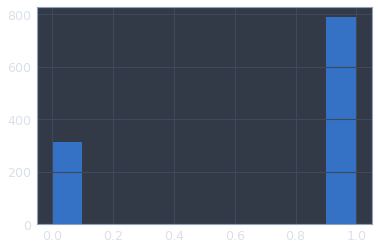

In [3]:
print(data.y.unique())
plt.hist(data.y);

In [4]:
print(data.isnull().sum().sum())

num_1 = data[data.y == 1].shape[0] 
num_0 = data[data.y == 0].shape[0]

print(num_1, num_0, num_1 / (num_0 + num_1))

0
790 315 0.7149321266968326


# Common functions

In [5]:
def weight_init(name, shape):
    return tf.get_variable(name, initializer=tf.random_normal(shape=shape,
                                                              stddev=0.1))
def bias_init(name, shape):
    return tf.get_variable(name, initializer=tf.constant(0.1, shape=shape))

def elastic_net(x, l1, l2):
    return l1 * ( (1-l2) / 2 * tf.norm(x, 2) ** 2 + 
                   l2 * tf.norm(x, 1))

def batch_data(*matrxs, batch_size):
    for batch_i in range(matrxs[0].shape[0] // batch_size):
        yield tuple(x.iloc[batch_i * batch_size : (batch_i + 1) * batch_size] 
                     for x in matrxs)
        
def split_data(data, train_size=0.5, test_size=0.25, validate_size=0.25):
    train_data, test_val_data = ms.train_test_split(data, train_size=train_size)
    test_data, val_data = ms.train_test_split(test_val_data,
                                              train_size=test_size / (test_size+validate_size))
    
    train_X, train_y = train_data.drop('y', axis=1), train_data[['y']]
    test_X, test_y = test_data.drop('y', axis=1), test_data[['y']]
    validate_X, validate_y = val_data.drop('y', axis=1), val_data[['y']]
    
    return (train_X, train_y, test_X, test_y, validate_X, validate_y)

def pp_pipeline(data):
    scaler = pp.StandardScaler()
    
    data_pp = scaler.fit_transform(data)
    
    data_pp = pd.DataFrame(data_pp,
                        index=data.index,
                        columns=data.columns)
    
    #restore target
    data_pp.y = data.y
    
    return data_pp

# Feature selection

## DFS

In [6]:
class DFS:
    def __init__(self, layers_sizes, batch_size=32, lambda1=1e-3, lambda2=1.,
                 alpha1=1e-3, alpha2=0.):
        self.layers_sizes = layers_sizes
        self.num_layers = len(layers_sizes)
        self.batch_size = batch_size
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        
        
    def fit(self, X, y, num_epochs=10, test_data=None):
        self._build_graph_(X.shape[1])
        self.sess = tf.Session()
        
        self.sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(num_epochs):
            X_cur = X.sample(frac=1, random_state=epoch_i)
            y_cur = y.sample(frac=1, random_state=epoch_i)
            epoch_loss = 0
            for batch_X, batch_y in batch_data(X_cur, y_cur, 
                                               batch_size=self.batch_size):
                train_loss, _ = self.sess.run([self.total_loss, self.train_step],
                                               feed_dict = {self.x: batch_X,
                                                            self.y: batch_y})
                epoch_loss += train_loss
            epoch_loss /= X.shape[0] // self.batch_size
            
            train_predict = self.predict(X_cur)
            train_accuracy = mtcs.accuracy_score(y_cur, train_predict)
            if test_data is not None:
                test_X, test_y = test_data
                test_predict = self.predict(test_X)
                test_accuracy = mtcs.accuracy_score(test_y, test_predict)
                print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}."
                      f"Train accuracy: {train_accuracy}. Test accuracy: {test_accuracy}.")
            else:
                print(f"==> Epoch: {epoch_i}. Train loss: {epoch_loss}. "
                      f"Train accuracy: {train_accuracy}.")
            
    def predict_proba(self, X):
        predictions_proba = self.sess.run(self.predictions, feed_dict={self.x: X})
        
        return predictions_proba
    def predict(self, X):
        predictions_proba = self.predict_proba(X)
        
        return list(map(np.argmax, predictions_proba))
    
    def get_features_weights(self):
        weights = self.sess.run(self.features_weights)
        
        return weights
        
    def _build_graph_(self, num_features):
        tf.reset_default_graph()
        
        ###Placeholders 
        x = tf.placeholder(tf.float32, [None, num_features], 'x_ph')
        y = tf.placeholder(tf.int32, [None], 'y_ph')
        
        ###Weights initialization
        w = tf.get_variable("dfs_features_weight", 
                            initializer = tf.constant(1., shape=[num_features]))
        self.layers_sizes = [num_features] + self.layers_sizes
        W, b = [], []
        for layer_i in range(self.num_layers):
            W.append(weight_init(f"layer_{layer_i}_weights",
                                 shape=[self.layers_sizes[layer_i],
                                        self.layers_sizes[layer_i+1]]))
            b.append(bias_init(f"layer_{layer_i}_bias",
                               shape=[self.layers_sizes[layer_i+1]]))
        
        ###Input transformations
        logits = x * w #feature selection
        for layer_i in range(self.num_layers):
            if layer_i != self.num_layers - 1:
                logits = tf.nn.tanh(tf.matmul(logits, W[layer_i]) + b[layer_i])
            else:
                logits = tf.matmul(logits, W[layer_i]) + b[layer_i]
        predictions = tf.nn.softmax(logits)
            
        ###Loss calculation
        logloss = tf.reduce_sum(
                        tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                                       logits=logits))
        w_loss = elastic_net(w, self.lambda1, self.lambda2)
        W_loss = tf.reduce_sum([elastic_net(W_i, self.alpha1, self.alpha2) for W_i in W])
        
        total_loss = tf.reduce_sum(logloss + w_loss + W_loss)
        
        ###Optimizer
        train_step = tf.train.AdamOptimizer(0.01).minimize(total_loss)
        
        self.x = x
        self.y = y
        self.predictions = predictions
        self.total_loss = total_loss
        self.train_step = train_step
        self.features_weights = w
        

In [7]:
data = pp_pipeline(_data_)

(train_X, train_y,
 test_X, test_y,
 validate_X, validate_y) = split_data(data)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [25]:
dfs = DFS([128, 64, 2])

dfs.fit(train_X, train_y['y'], num_epochs=200, test_data=(test_X, test_y))

==> Epoch: 0. Train loss: 20.698773440192728.Train accuracy: 0.8568840579710145. Test accuracy: 0.8188405797101449.
==> Epoch: 1. Train loss: 14.034187709583955.Train accuracy: 0.7898550724637681. Test accuracy: 0.7318840579710145.
==> Epoch: 2. Train loss: 12.161317572874182.Train accuracy: 0.9221014492753623. Test accuracy: 0.8623188405797102.
==> Epoch: 3. Train loss: 10.900635691250072.Train accuracy: 0.8713768115942029. Test accuracy: 0.8152173913043478.
==> Epoch: 4. Train loss: 10.529738370110007.Train accuracy: 0.9492753623188406. Test accuracy: 0.8442028985507246.
==> Epoch: 5. Train loss: 8.623933553695679.Train accuracy: 0.9438405797101449. Test accuracy: 0.8188405797101449.
==> Epoch: 6. Train loss: 8.28262186050415.Train accuracy: 0.9239130434782609. Test accuracy: 0.8152173913043478.
==> Epoch: 7. Train loss: 8.815423264222986.Train accuracy: 0.9438405797101449. Test accuracy: 0.8659420289855072.
==> Epoch: 8. Train loss: 7.680413162007051.Train accuracy: 0.95652173913043

==> Epoch: 72. Train loss: 4.81421288322.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 73. Train loss: 4.7500397177303535.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 74. Train loss: 4.686646068797392.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 75. Train loss: 4.62400873969583.Train accuracy: 1.0. Test accuracy: 0.8586956521739131.
==> Epoch: 76. Train loss: 4.562357341541963.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 77. Train loss: 4.50129820318783.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 78. Train loss: 4.440899989184211.Train accuracy: 1.0. Test accuracy: 0.8586956521739131.
==> Epoch: 79. Train loss: 4.381542009465835.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 80. Train loss: 4.322642719044405.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 81. Train loss: 4.264688323525822.Train accuracy: 1.0. Test accuracy: 0.8623188405797

==> Epoch: 154. Train loss: 1.5057174388100119.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 155. Train loss: 1.4831381895962883.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 156. Train loss: 1.4608733443652882.Train accuracy: 1.0. Test accuracy: 0.8586956521739131.
==> Epoch: 157. Train loss: 1.4388742587145638.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 158. Train loss: 1.417176134446088.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 159. Train loss: 1.3957882839090683.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 160. Train loss: 1.37467622756958.Train accuracy: 1.0. Test accuracy: 0.8623188405797102.
==> Epoch: 161. Train loss: 1.3538562620387358.Train accuracy: 1.0. Test accuracy: 0.8586956521739131.
==> Epoch: 162. Train loss: 1.3333268025342155.Train accuracy: 1.0. Test accuracy: 0.8586956521739131.
==> Epoch: 163. Train loss: 1.313039968995487.Train accuracy: 1.0. Test accu

In [21]:
predictions = dfs.predict(test_X)

mtcs.accuracy_score(test_y, predictions)

0.87681159420289856

In [22]:
predictions = dfs.predict(train_X)

mtcs.accuracy_score(train_y, predictions)

0.99818840579710144

In [23]:
sorted(dfs.get_features_weights())

[-0.75992769,
 -0.62013346,
 -0.60503143,
 -0.5654999,
 -0.54240173,
 -0.53474188,
 -0.45321685,
 -0.4406743,
 -0.40924022,
 -0.40725744,
 -0.40707994,
 -0.40247804,
 -0.3919872,
 -0.38696951,
 -0.38419285,
 -0.37311167,
 -0.36889973,
 -0.36351943,
 -0.35403028,
 -0.348252,
 -0.33356601,
 -0.33067447,
 -0.3272438,
 -0.31660348,
 -0.31044716,
 -0.29065377,
 -0.28779611,
 -0.28259054,
 -0.27549115,
 -0.26608464,
 -0.25593001,
 -0.25565973,
 -0.24113506,
 -0.23670696,
 -0.23133986,
 -0.23050651,
 -0.21184336,
 -0.20612961,
 -0.20592104,
 -0.19491744,
 -0.19195493,
 -0.18730195,
 -0.18535876,
 -0.18091781,
 -0.17901501,
 -0.17005686,
 -0.1663736,
 -0.16355778,
 -0.16102479,
 -0.15966496,
 -0.15522167,
 -0.15414613,
 -0.15410955,
 -0.15392849,
 -0.1538527,
 -0.1500883,
 -0.14878738,
 -0.14572047,
 -0.14560789,
 -0.14304115,
 -0.13803446,
 -0.12875648,
 -0.12801179,
 -0.12764524,
 -0.12500346,
 -0.12077368,
 -0.11741283,
 -0.11667877,
 -0.11563471,
 -0.11549851,
 -0.11518297,
 -0.11470037,
 

(array([  1.20000000e+01,   1.05000000e+02,   1.05200000e+03,
          1.86000000e+02,   1.02000000e+02,   4.40000000e+01,
          1.70000000e+01,   5.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([-0.75992769, -0.39621627, -0.03250484,  0.33120658,  0.694918  ,
         1.05862942,  1.42234085,  1.78605227,  2.14976369,  2.51347511,
         2.87718654]),
 <a list of 10 Patch objects>)

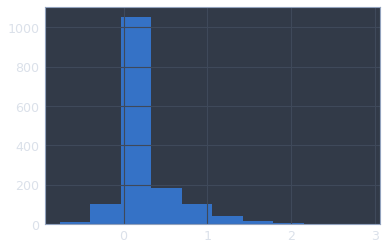

In [24]:
plt.hist(dfs.get_features_weights())